In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow.keras.preprocessing as prep
from sklearn.model_selection import train_test_split
from model import AugementedConvLSTM
import h5py
import itertools

In [2]:
Aug_ConvLSTM_model = AugementedConvLSTM(
    projection_height = 129, 
    projection_width = 135,
    timesteps=4
    )
model = Aug_ConvLSTM_model.model(
    [32, 16, 16], 
    [9,5,3], 
    [64,32,1], 
    [9,3,5], 
    2
    )

2022-06-30 16:17:04.457920: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-30 16:17:07.278191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8668 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2022-06-30 16:17:07.279592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9631 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-06-30 16:17:07.281238: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/r

In [10]:
model.load_weights('convlstm_weights_pr.h5')

In [9]:
def Process(i = 0, model = None, mask = [1,1,1,1,1], rf_idx = 1, end_index = 1000, show_plots = [1,1,1], Overwrite = False, modified = False):
    def load_dataset():
        filepath = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data"
        rf = np.array(np.load(os.path.join(filepath,rf"r{rf_idx}.npy")))[:end_index,:,:]
        X = np.empty((7,end_index,129,135))
        X[0,:,:,:] = np.array(np.load(r"MIROC-ESM.npy"))[:end_index,:,:] if mask[0] else np.array(rf)
        X[1,:,:,:] = np.array(np.load(r"elev.npy"))[:end_index,:,:] if mask[1] else np.array(rf)
        X[2,:,:,:] = np.array(np.load(os.path.join(filepath,rf"rhum.npy")))[:end_index,:,:] if mask[2] else np.array(rf)
        X[3,:,:,:] = np.array(np.load(os.path.join(filepath,rf"pres.npy")))[:end_index,:,:] if mask[3] else np.array(rf)
        X[4,:,:,:] = np.array(np.load(os.path.join(filepath,rf"uwnd.npy")))[:end_index,:,:] if mask[4] else np.array(rf)
        X[5,:,:,:] = np.array(np.load(os.path.join(filepath,rf"vwnd.npy")))[:end_index,:,:] if mask[4] else np.array(rf)
        X[6,:,:,:] = np.array(np.load(os.path.join(filepath,rf"omega.npy")))[:end_index,:,:] if mask[4] else np.array(rf)
        # print(X.shape)
        Y = np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data/IMD.npy")[:,:end_index,:,:]
        return X, Y
    def normalize(data):
        data = data - data.mean()
        data = data / data.std()
        return data
    def data_generator(X,Y):
        time_steps = 4
        batch_size1 = 1
        generator = prep.sequence.TimeseriesGenerator(
            X, 
            Y.reshape(-1, 129, 135, 1),
            length=time_steps, 
            batch_size=batch_size1
            )
        return generator
    def set_data(X, Y):
        X_normalized = np.zeros((7, end_index, 129, 135))
        for i in range(7):
            X_normalized[i,] = normalize(X[i,])
        Y_normalized = normalize(Y)
        # print("Mean of GCM Data: ",X[0,].mean())
        # print("Variance of GCM Data: ",X[0,].std(),end="\n")
        # print("Mean of Obseved Data: ",Y.mean())
        # print("Variance of Obseved Data: ",Y.std(),end="\n")
        std_observed = Y.std()
        # X = X_normalized.transpose(1,2,3,0)
        # Y = Y_normalized.reshape(-1,129, 135, 1)
        return data_generator(X_normalized.transpose(1,2,3,0), Y_normalized.reshape(-1,129, 135, 1))
    
    if not Overwrite:
        try:
            Y = np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data/IMD.npy")[:,:end_index,:,:]
            if modified:
                yy_hat = np.load(rf"Data/modified_yy_hat_{i}.npy")
            else:
                yy_hat = np.load(rf"Data/yy_hat_{i}.npy")

            Y = normalize(Y).reshape(-1,129, 135, 1)
        except:
            X, Y = load_dataset()
            generator = set_data(X, Y)
            yy_hat = model.predict(generator)
            if modified:
                np.save(rf"Data/modified_yy_hat_{i}.npy", yy_hat)
            else:
                np.save(rf"Data/yy_hat_{i}.npy", yy_hat)
            del X, generator
    else:
        X, Y = load_dataset()
        generator = set_data(X, Y)
        yy_hat = model.predict(generator)
        if modified:
            np.save(rf"Data/modified_yy_hat_{i}.npy", yy_hat)
        else:
            np.save(rf"Data/yy_hat_{i}.npy", yy_hat)
        del X, generator
    
    calc = []

    Y_hat = np.array(yy_hat).reshape(-1,129,135)
    data = np.array(np.mean(Y_hat, axis = 0))
    print(f"Y_hat (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
    calc += [round(np.nanmin(data),3), round(np.nanmax(data),3), round(np.nanmean(data),3)]
    FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy"
    mask = np.load(FileName)
    indices = np.where(mask == 0)
    data[indices] = np.nan
    if show_plots[0]:
        fig,ax = plt.subplots(1,2, figsize = (20,10))
        sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
        ax[0].axis('off')
        ax[1].boxplot(data[~np.isnan(data)], vert = False)
        plt.show()
        del fig, ax
    del Y_hat, data, FileName, mask, indices

    Y_Obs = np.array(np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data/IMD.npy")[:,:end_index,:,:]).reshape(-1,129,135)[4:]
    Y_hat = np.array(yy_hat.reshape(-1,129,135))
    data = np.array(np.mean((Y_hat*Y_Obs.std())+Y_Obs.mean(), axis = 0))
    print(f"Y_hat (Scaled) (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
    calc += [round(np.nanmin(data),3), round(np.nanmax(data),3), round(np.nanmean(data),3)]
    FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy"
    mask = np.load(FileName)
    indices = np.where(mask == 0)
    data[indices] = np.nan
    data[indices] = np.nan
    if show_plots[1]:
        fig,ax = plt.subplots(1,2, figsize = (20,10))
        sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
        ax[0].axis('off')
        ax[1].boxplot(data[~np.isnan(data)], vert = False)
        plt.show()
        del fig, ax
    del Y_hat, Y_Obs, data, FileName, mask, indices

    Y_Obs = np.array(np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data/IMD.npy")[:,:end_index,:,:]).reshape(-1,129,135)[4:]
    Y_hat = np.array(yy_hat.reshape(-1,129,135))
    data = np.array(np.sqrt(np.sum(np.square(((Y_hat*Y_Obs.std())+Y_Obs.mean()) - Y_Obs), axis = 0)/Y_hat.shape[0]))
    print(f"RMSE (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
    calc += [round(np.nanmin(data),3), round(np.nanmax(data),3), round(np.nanmean(data),3)]
    FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy"
    mask = np.load(FileName)
    indices = np.where(mask == 0)
    data[indices] = np.nan
    threshold_99 = np.nanpercentile(data, 99)
    indices = np.where(data > threshold_99)
    data[indices] = np.nan
    if show_plots[2]:
        fig,ax = plt.subplots(1,2, figsize = (20,10))
        sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
        ax[0].axis('off')
        ax[1].boxplot(data[~np.isnan(data)], vert = False)
        plt.show()
        del fig, ax
    del Y_hat, Y_Obs, data, FileName, mask, indices, threshold_99

    return calc

Y_hat (Min, Max, Mean) = (-0.23899999260902405, 3.937999963760376, -0.014000000432133675) mm/day


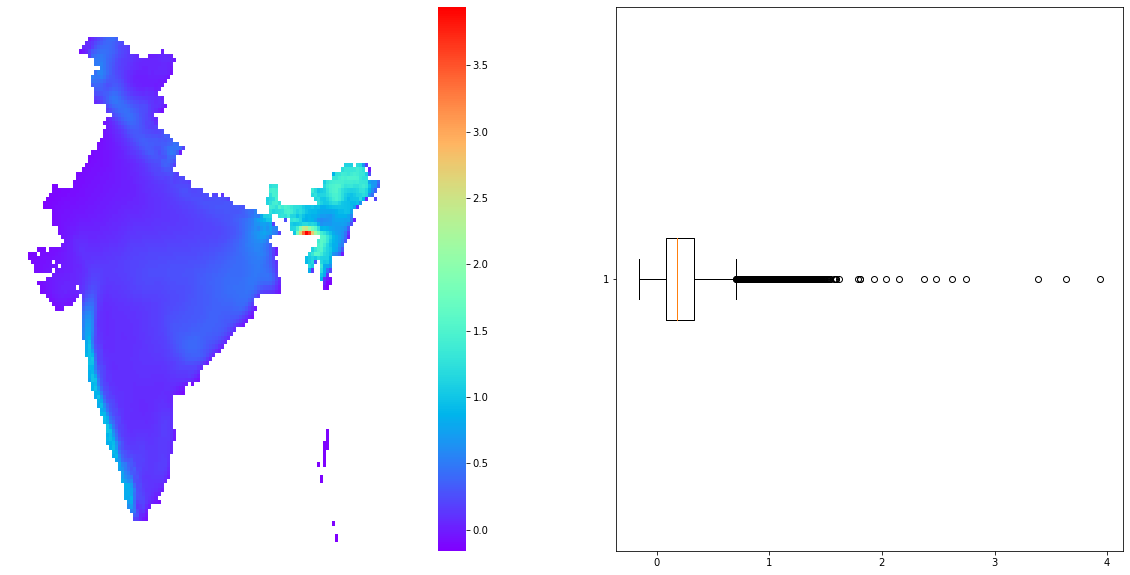

Y_hat (Scaled) (Min, Max, Mean) = (-0.5180000066757202, 24.159000396728516, 0.8130000233650208) mm/day


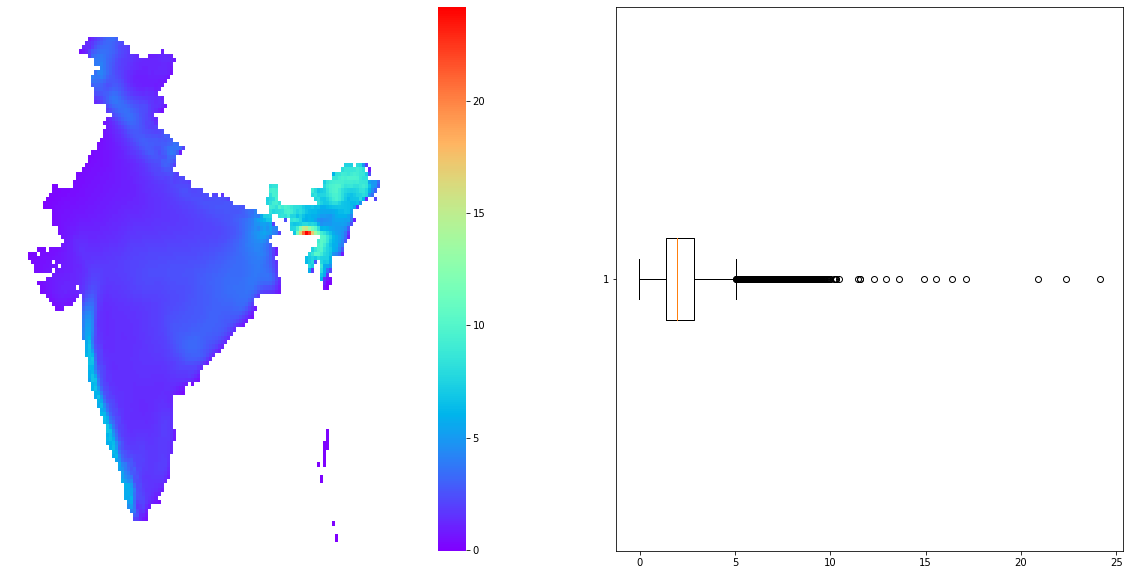

RMSE (Min, Max, Mean) = (0.044, 46.673, 2.624) mm/day


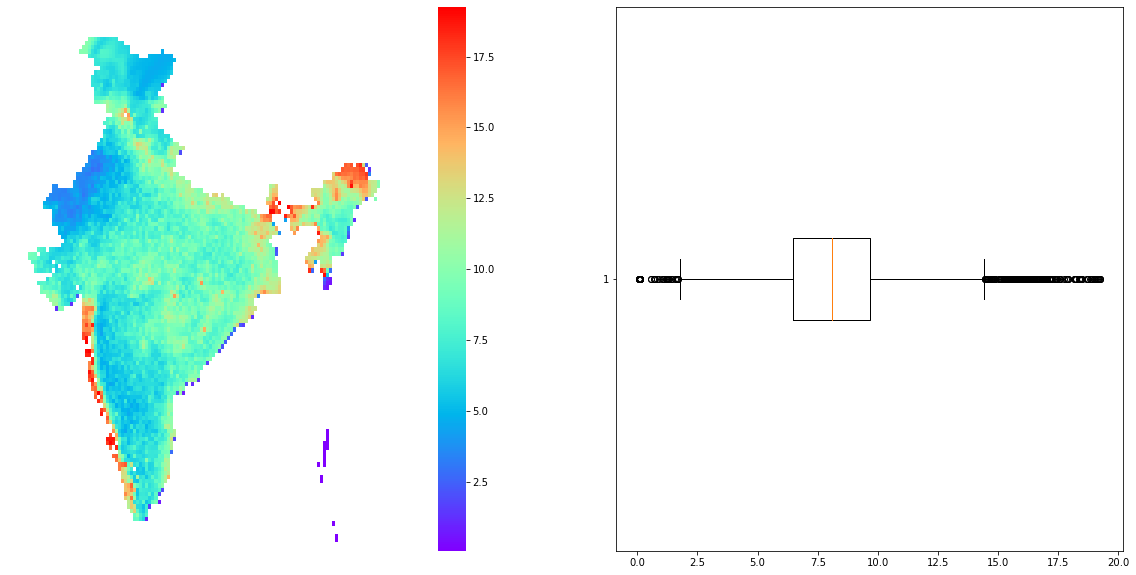

In [11]:
Process(
    i = 17, 
    model = model, 
    mask = [0,1,1,1,1], 
    rf_idx = 1, 
    end_index = 21185,
    show_plots = [1,1,1],
    Overwrite = True,
    modified = False
    );

In [12]:
model.load_weights('convlstm_weights_pr_modified.h5')

Y_hat (Min, Max, Mean) = (-0.20399999618530273, 1.190999984741211, -0.03400000184774399) mm/day


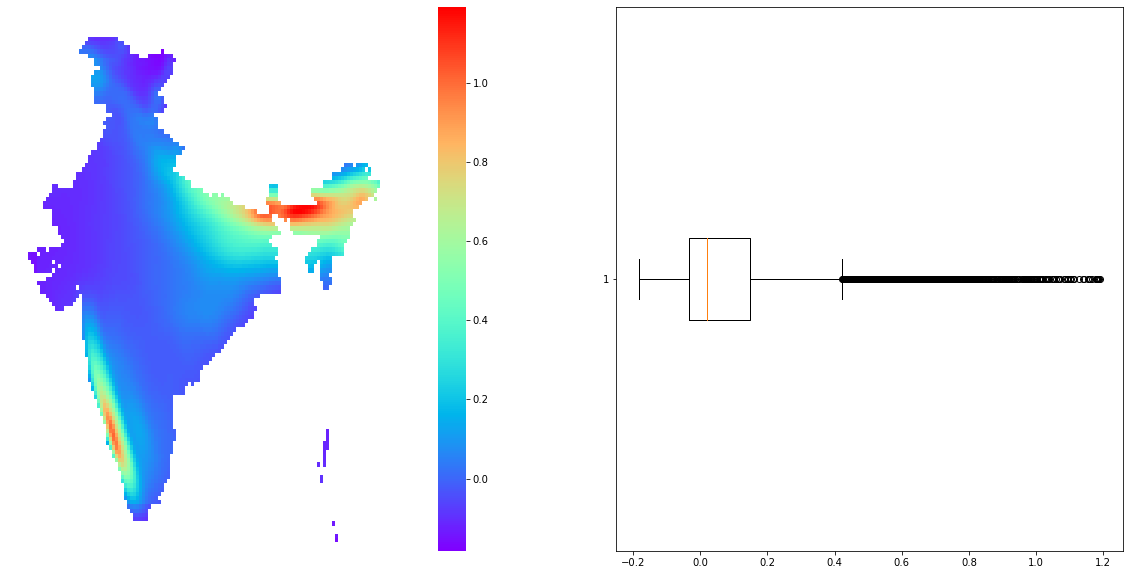

Y_hat (Scaled) (Min, Max, Mean) = (-0.31299999356269836, 7.926000118255615, 0.6930000185966492) mm/day


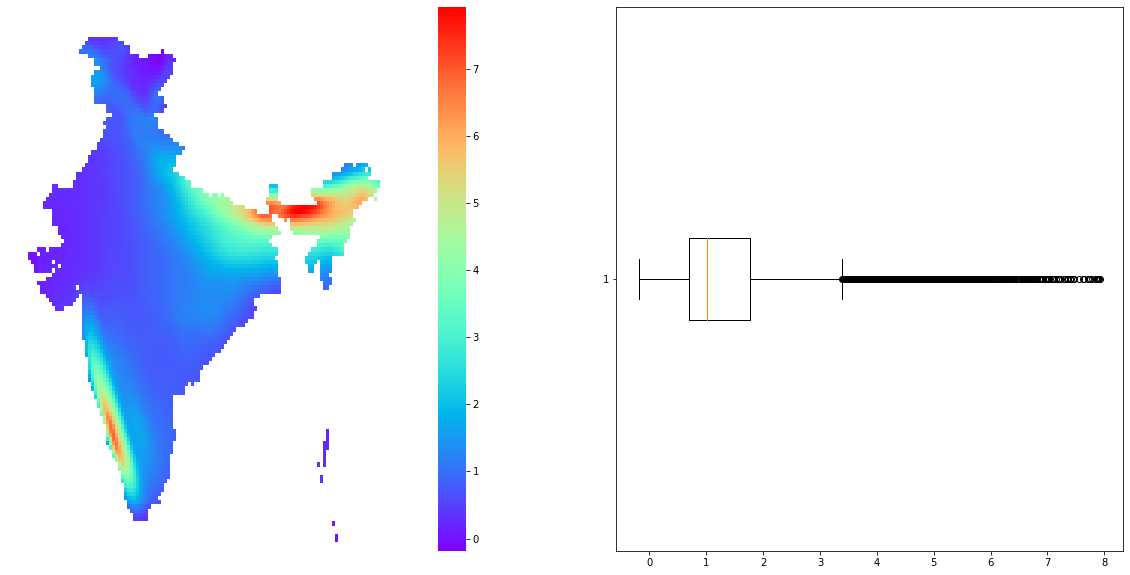

RMSE (Min, Max, Mean) = (0.045, 55.352, 3.273) mm/day


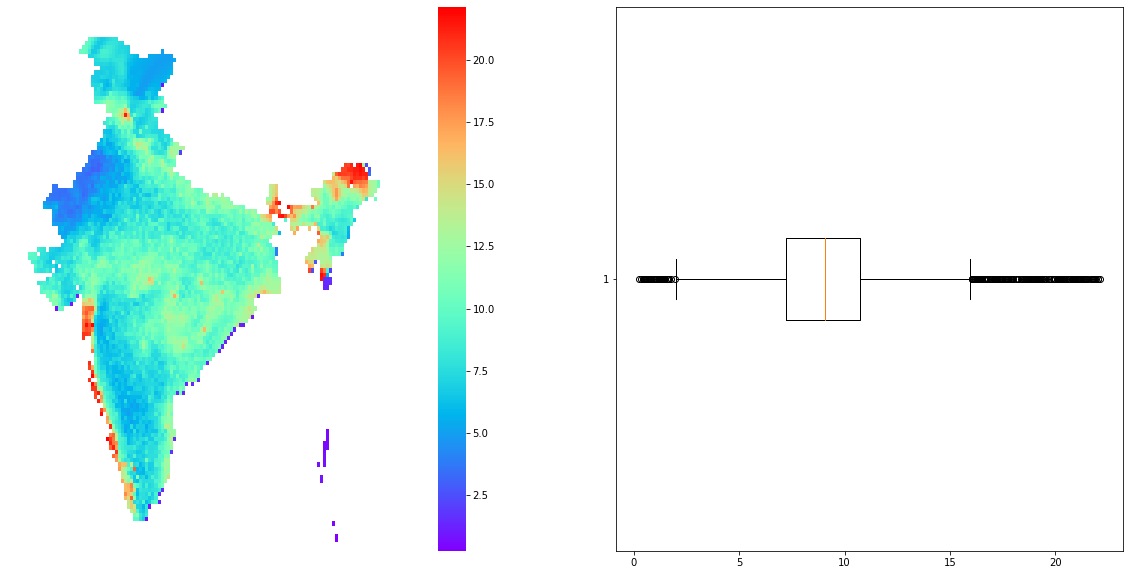

In [13]:
Process(
    i = 17, 
    model = model, 
    mask = [0,1,1,1,1], 
    rf_idx = 1, 
    end_index = 21185,
    show_plots = [1,1,1],
    Overwrite = True,
    modified = True
    );